# Web Scraping for Indeed.com and Predicting Salaries - Data Cleaning

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import re

-----

#### Cleaning the data

In [4]:
c1 = pd.read_csv('Job_listings_australia.csv')
c2 = pd.read_csv('Job_listings_canada_1.csv')
c3 = pd.read_csv('Job_listings_united_kingdom.csv')
c4 = pd.read_csv('Job_listings_usa.csv')

In [7]:
df = pd.concat([c1,c2,c3,c4])
df.dropna(subset=['job_title', 'company', 'location'], inplace=True)

There are some columns with new attatched to the title and these could be duplicates as a new job could be an old job depending when I carried out the scrape.

In [9]:
def strip_new(x):
    if 'new' in x:
        return x.replace('new', '')
    else:
        return x

In [10]:
df['job_title'] = df.job_title.apply(strip_new)

In [21]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

Save final job to csv

In [27]:
df.to_csv('job_listings_full.csv', index=False)

And now strip only the columns with salary from this dataframe to obtain the dataframe we will work with for the modelling process.

In [33]:
df_salary = df.dropna().reset_index(drop=True)
df_salary.to_csv('job_listings_salary.csv', index=False)

Now we have our final dataframe for the mdoelling stage. But we still need to clean it.

In [32]:
df_salary.head()

,job_title,company,location,salary,country
0,Marketing Data analyst,HAYS,Melbourne VIC,"$80,000 a year",australia
1,Supply Chain Analyst,Michael Page,Melbourne VIC,"$80,000 - $90,000 a year",australia
2,Data Architect - Financial Services - Data & A...,EY,Melbourne VIC 3000,"$90,000 a year",australia
3,Senior Data Business Analyst,Talent International,Melbourne VIC,"$900 - $1,200 a day",australia
4,Senior Data Warehouse Analyst - Education,Charterhouse,Docklands VIC,"$116,547 a year",australia


#### Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

In [310]:
df_salary = pd.read_csv('job_listings_salary.csv')

In [311]:
hour = 0
day = 0
week = 0
month = 0
year = 0
other = 0
other_index = []

for i, x in enumerate(df_salary.salary):
    if 'hour'in x:
        hour += 1
    elif 'day' in x:
        day += 1
    elif 'week' in x:
        week += 1
    elif 'month' in x:
        month += 1
    elif 'year' in x:
        year += 1
    else:
        other+= 1
        other_index.append(i)

Check what salary types there are and if there are other types not included in the obvious ones including their index to be able to look at them.

In [312]:
print('hour:', hour)
print('day:', day)
print('week:', week)
print('month:', month)
print('year:', year)
print('other:', other)

hour: 222
day: 81
week: 16
month: 31
year: 2941
other: 0


#### I will create a new column indicating whether the salary displayed is hourly, dayly... to later multiply and make all values yearly.

In [313]:
def extract_time_frame(x):
    if 'hour'in x:
        return 'hour'
    elif 'day' in x:
        return 'day'
    elif 'week' in x:
        return 'week'
    elif 'month' in x:
        return 'month'
    elif 'year' in x:
        return 'year'

In [314]:
df_salary['time_frame'] = df_salary['salary'].apply(extract_time_frame)

#### Cleaning the salary column to leave just numbers and dashes

In [315]:
def clean_salary(x):
    return re.sub(r'[^0-9-.]', '', x)

In [316]:
df_salary.salary = df_salary.salary.apply(clean_salary)

In [317]:
df_salary.salary.head()

0          80000
1    80000-90000
2          90000
3       900-1200
4         116547
Name: salary, dtype: object

In [318]:
def averages_int(x):
    if '-' in x:
        a,b = x.split('-')
        return int((float(a)+float(b))/2)
    else:
        return int(float(x))

In [319]:
df_salary.salary = df_salary.salary.apply(averages_int)

-----

#### Obtaining the latest currency exchange rates

In [320]:
from forex_python.converter import CurrencyRates


# Obtaining the latest currency exchanges
c = CurrencyRates()
usd_gbp = round(c.get_rate('USD', 'GBP'),3)
cad_gbp = round(c.get_rate('CAD', 'GBP'),3)
aud_gbp = round(c.get_rate('AUD', 'GBP'),3)

#### Obtaining the index locations for the respective countries. ( We are changing everything to GPB so uk is not included ).

In [321]:
us_index = df_salary[df_salary['country'] == 'united states'].index
aus_index = df_salary[df_salary['country'] == 'australia'].index
cad_index = df_salary[df_salary['country'] == 'Canada'].index

In [322]:
df_salary.salary.loc[us_index] = df_salary.salary*usd_gbp
df_salary.salary.loc[aus_index] = df_salary.salary*aud_gbp
df_salary.salary.loc[cad_index] = df_salary.salary*cad_gbp

/Users/ariklevy/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Changing every salary entry to yearly and dropping the time frame column we created above as we don´t need it anymore.

In [323]:
df_salary.salary.loc[df_salary[df_salary['time_frame'] == 'hour'].index] = df_salary.salary*40*52
df_salary.salary.loc[df_salary[df_salary['time_frame'] == 'day'].index] = df_salary.salary*5*52
df_salary.salary.loc[df_salary[df_salary['time_frame'] == 'week'].index] = df_salary.salary*52
df_salary.salary.loc[df_salary[df_salary['time_frame'] == 'month'].index] = df_salary.salary*12

In [324]:
df_salary.drop('time_frame', axis=1, inplace=True)

In [325]:
df_salary[df_salary['salary'] < 3000]

,job_title,company,location,salary,country
1977,Data Entry Clerk III,1199SEIU Benefit and Pension Funds,"New York, NY",30.192,united states
1978,Recruitment Coordination Team Lead,Spotify,"Remote in New York, NY+2 locations",57.120,united states
1979,Data Processing Helper,Tompkins County,"Tompkins County, NY",37.536,united states
1980,CRM Data Analyst,Bard College,"Annandale-on-Hudson, NY 12504",53.856,united states
1981,Data Analyst,GlossGenius,"Remote in New York, NY+1 location",72.624,united states
...,...,...,...,...,...
2876,Junior Study Designer,NEFORM by NESS,"Brookline, MA",48.960,united states
2877,Data Scientist,Pison,"Boston, MA",94.656,united states
2878,Anticipated Administrative Assistant to Specia...,Old Rochester Regional School District/MA Supt...,"Mattapoisett, MA 02739",35.904,united states
2879,Senior Principal Strategist,Cambridge Consultants Ltd,"Boston, MA",82.416,united states


Finally I noticed that some columns in the data had a 'k' instead of the numerical value of 1000, so we have to change those rows and multiply them by a 1000.

There are 904 rows with this issue which is imperative we fix it.

In [326]:
def k_to_thousand(x):
    if x < 1000:
        return x*1000
    else:
        return x

In [327]:
df_salary.salary = df_salary.salary.apply(k_to_thousand)

### Save results as a CSV

In [165]:
df_salary.to_csv('job_listings_clean_salary.csv', index=False)

### Load in the the data of scraped salaries

In [211]:
df_salary = pd.read_csv('job_listings_clean_salary.csv')

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

The salary column is slightly skewed

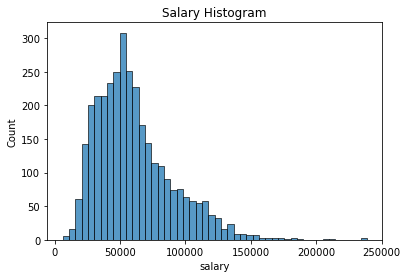

In [214]:
plt.title('Salary Histogram')
sns.histplot(df_salary.salary);

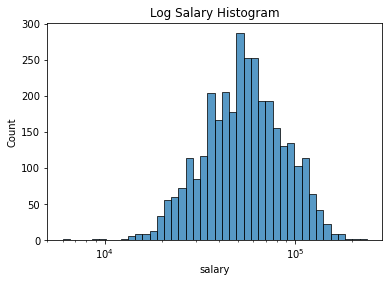

In [10]:
plt.title('Log Salary Histogram')
sns.histplot(df_salary.salary, log_scale=True);

I will apply a log transformation to the salary column to make it normally distributed

In [11]:
df_salary.salary =  np.log(df_salary.salary)

Now I will split the salary column into four categories, depending on whether the salary likes below the lower queartile, between the lower quartile and the median, between the median and the upper quartile, or higher than the upper quartile.

### Split into 4 categories as a way to future imrove on this project. For now I will keep it binary.

In [215]:
def salary_categories(x):
   
    min_ = df_salary.salary.min()
    low_q = df_salary.salary.quantile(0.25)
    median = df_salary.salary.quantile(0.5)
    high_q = df_salary.salary.quantile(0.75)
    max_ = df_salary.salary.max()
    
    if min_ <= x < low_q:
        return 0
    if low_q <= x < median:
        return 1
    if median <= x < high_q:
        return 2
    if high_q < x <= max_:
        return 3

In [216]:
df_salary['salary_cat'] = df_salary.salary.apply(salary_categories)

In [217]:
def salary_binary(x):

    median = df_salary.salary.quantile(0.5)
    
    if x < median:
        return 0
    else:
        return 1

In [218]:
df_salary['salary_binary'] = df_salary.salary.apply(salary_binary)

#### Thought experiment: What is the baseline accuracy for this model?

In [219]:
df_salary['salary_cat'].value_counts(normalize=True)

3    0.250076
2    0.250076
0    0.250076
1    0.249772
Name: salary_cat, dtype: float64

In [220]:
df_salary['salary_binary'].value_counts(normalize=True)

1    0.500152
0    0.499848
Name: salary_binary, dtype: float64

--------

-----

## Cleaning the location category

In [221]:
def remote_hybrid_none(x):
    if re.match(r'(h|H)ybrid', x) and re.match(r'(r|R)emote', x):
        return 'Hybrid'
    
    elif re.match(r'(h|H)ybrid', x):
        return 'Hybrid'

    elif re.match(r'(r|R)emote', x):
        return 'Remote'
    
    else:
        return 'Office'

df_salary['remote'] = df_salary.location.apply(remote_hybrid_none)

In [222]:
repl = [r'(r|R)emote', r'(h|H)ybrid', '+', 'in', r'locations?', '(The Loop area)', '(Loop area)',
        '(Midtown area)', '(Fancial District/South Beach area)', 'Temporarily', 'Region', r'[^a-zA-Z ]+']

for item in repl:
    df_salary.location = df_salary.location.str.replace(item, '')
    
## Removing all white space from the column, after having replaced the items above.
df_salary.location = df_salary.location.str.rstrip().str.lstrip()

## Cleaning different instances of 1,2 & 3 sets of letter that were in the column
df_salary.location = df_salary.location.str.replace(r'( \w{3}$)', '')
df_salary.location = df_salary.location.str.replace(r'( \w{3} )', '')
df_salary.location = df_salary.location.str.replace(r'( \w{2}$)', '')
df_salary.location = df_salary.location.str.replace(r'( \w{1}$)', '')
df_salary.location = df_salary.location.str.replace(r'( \w{1} )', '')

/var/folders/0g/2n4dpfnj6xg2x7twpn7nk6nh0000gn/T/ipykernel_11436/1390068497.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_salary.location = df_salary.location.str.replace(item, '')
/var/folders/0g/2n4dpfnj6xg2x7twpn7nk6nh0000gn/T/ipykernel_11436/1390068497.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_salary.location = df_salary.location.str.replace(item, '')
/var/folders/0g/2n4dpfnj6xg2x7twpn7nk6nh0000gn/T/ipykernel_11436/1390068497.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df_salary.location = df_salary.location.str.replace(r'( \w{3}$)', '')
/var/folders/0g/2n4dpfnj6xg2x7twpn7nk6nh0000gn/T/ipykernel_11436/1390068497.py:12: FutureWarning: The default value of regex will change from True to False in a fu

One mistake from the cleaning above is that columns that were purely Remote also got removed so I will add these back in.

In [223]:
def add_remote(x):
    if x == '':
        return 'Remote'
    else:
        return x
df_salary.location = df_salary.location.apply(add_remote)

In [224]:
cities = []
pattern = re.compile(r'(^\w+\s\w+)')
pattern2 = re.compile(r'(^\w+)')

for x in df_salary.location:
    if re.findall(pattern, x) != []:
        cities.append(re.findall(pattern, x))
    else:
        cities.append(re.findall(pattern2, x))
df_salary['city'] = [item for sublist in cities for item in sublist]

------

In [225]:
subset = df_salary.city.value_counts().nlargest(20).index
subset

Index(['London', 'Bristol', 'Manchester', 'San Francisco', 'Leeds', 'New York',
       'Aust', 'Edburgh', 'Glasgow', 'Chicago', 'Sydney', 'Remote',
       'Melbourne', 'Toronto', 'Birmgham', 'Boston', 'Philadelphia',
       'Brisbane', 'Dallas', 'Orlando'],
      dtype='object')

In [261]:
def filter_more(x):

        if 'Melbourne' in x:
            return 'Melbourne'
        
        elif 'Bristol' in x:
            return 'Bristol'
   
        elif 'Manchester' in x:
            return 'Manchester'
        
        elif 'Bristol' in x:
            return 'Bristol'
        
        elif 'San Francisco' in x:
            return 'San Francisco' 
        
        elif 'Leeds' in x:
            return 'Leeds'
        
        elif 'New York' in x:
            return 'New York'
        
        elif 'Aust' in x:
            return 'Aust'
        
        elif 'Edburgh' in x:
            return 'Edburgh'
        
        elif 'Glasgow' in x:
            return 'Glasgow' 
        
        elif 'Chicago' in x:
            return 'Chicago'

        elif 'Sydney' in x:
            return 'Sydney'
        
        elif 'Remote' in x:
            return 'Remote'
        
        elif 'Melbourne' in x:
            return 'Melbourne'
        
        elif 'Toronto' in x:
            return 'Toronto' 
        
        elif 'Birmgham' in x:
            return 'Birmgham'
        
        elif 'Boston' in x:
            return 'Boston'
        
        elif 'Philadelphia' in x:
            return 'Philadelphia'
        
        elif 'Brisbane' in x:
            return 'Brisbane'
        
        elif 'Dallas' in x:
            return 'Dallas' 
        
        elif 'Orlando' in x:
            return 'Orlando'
        
        elif 'Adelaide' in x:
            return 'Adelaide'
        
        elif 'Baltimore' in x:
            return 'Baltimore'
        
        elif 'London' in x:
            return 'London'
        
        else:
            return x

In [262]:
df_salary.city = df_salary.city.apply(filter_more)

---------------

## Cleaning the Job category

I noticed upon inspection that some job categories have the word remote in them, I will strip them and make sure the remote category is correctly labeled for these jobs.

In [228]:
def clean_job(x):
    return re.sub(r'(R|r)emote', '', x.title())


In [229]:
def clean_job_numeric(x):
    return re.sub('([0-9-]+)', '', x)

In [230]:
df_salary.job_title.apply(clean_job_numeric)

0                                  Marketing Data analyst
1                                    Supply Chain Analyst
2       Data Architect  Financial Services  Data & Ana...
3                            Senior Data Business Analyst
4                Senior Data Warehouse Analyst  Education
                              ...                        
3286                      Senior Director of Data Science
3287                               Data Scientist Manager
3288                               Director, Data Science
3289    Business Analyst  Text and Voice Modeling & An...
3290                AFNORTH Business Intelligence Analyst
Name: job_title, Length: 3291, dtype: object

In [231]:
df_salary.job_title = df_salary.job_title.str.rstrip().str.lstrip()
df_salary.job_title = df_salary.job_title.apply(clean_job)
df_salary.job_title = df_salary.job_title.apply(clean_job_numeric)

In [263]:
df_salary.to_csv('df_final_no_log', index=False)